In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from string import punctuation
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
data = pd.read_csv('all-data.csv', encoding='latin-1', names=['sentiment', 'text'])
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
# making list stopwords for removing stopwords from our text 
stop = set(stopwords.words('english'))
stop.update(punctuation)

In [6]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
lemmatizer = WordNetLemmatizer()
def clean_review(text):
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in stop:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    return clean_text

def join_text(text):
    return " ".join(text)

In [8]:
data.text = data.text.apply(clean_review)
data.text = data.text.apply(join_text)

In [9]:
data.head()

,sentiment,text
0,neutral,According Gran company plan move production Ru...
1,neutral,"Technopolis plan develop stage area less 100,0..."
2,negative,international electronic industry company Elco...
3,positive,new production plant company would increase ca...
4,positive,According company 's update strategy year 2009...


In [10]:
# splitting data.
x_train,x_test,y_train,y_test = train_test_split(data.text,data.sentiment,test_size = 0.2 , random_state = 0)

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3876,), (3876,), (970,), (970,))

## Vectorizer:

In [12]:
count_vec = CountVectorizer(max_features=4000, ngram_range=(1,2), max_df=0.9, min_df=0)

In [13]:
x_train_features = count_vec.fit_transform(x_train).todense()
x_test_features = count_vec.transform(x_test).todense()
x_train_features.shape, x_test_features.shape

((3876, 4000), (970, 4000))

In [15]:
nb_clf = MultinomialNB()
nb_clf.fit(x_train_features, y_train)
y_pred = nb_clf.predict(x_test_features)
print(accuracy_score(y_test,y_pred)*100)

71.1340206185567


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.52      0.54      0.53       128
     neutral       0.76      0.87      0.81       575
    positive       0.66      0.46      0.54       267

    accuracy                           0.71       970
   macro avg       0.65      0.62      0.63       970
weighted avg       0.70      0.71      0.70       970



In [17]:
y_train[y_train=='positive']=2
y_train[y_train=='neutral']=1
y_train[y_train=='negative']=0
y_test[y_test=='positive']=2
y_test[y_test=='neutral']=1
y_test[y_test=='negative']=0

encoder = OneHotEncoder()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((3876, 3), (970, 3))

# Neural Network - Baseline:

In [44]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [45]:
optimizer = 'sgd'
model = Sequential()
    
model.add(Dense(units=512, activation='relu', input_dim=x_train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [46]:
history = model.fit(x_train_features, y_train, 
                    validation_data=(x_test_features, y_test), 
                    epochs=100, 
                    batch_size = 32, verbose=1)
    
print('Accuracy with',optimizer,'optimizer is :',model.evaluate(x_test_features, y_test)[1]*100)

Train on 3876 samples, validate on 970 samples
Epoch 1/100
3876/3876 [==============================] - 3s 680us/step - loss: 1.0061 - acc: 0.5759 - val_loss: 0.9540 - val_acc: 0.5928
Epoch 2/100
3876/3876 [==============================] - 2s 587us/step - loss: 0.9282 - acc: 0.5947 - val_loss: 0.9186 - val_acc: 0.5928
Epoch 3/100
3876/3876 [==============================] - 2s 583us/step - loss: 0.8993 - acc: 0.5965 - val_loss: 0.8986 - val_acc: 0.5959
Epoch 4/100
3876/3876 [==============================] - 2s 584us/step - loss: 0.8821 - acc: 0.6032 - val_loss: 0.8812 - val_acc: 0.6113
Epoch 5/100
3876/3876 [==============================] - 2s 587us/step - loss: 0.8611 - acc: 0.6200 - val_loss: 0.8636 - val_acc: 0.6309
Epoch 6/100
3876/3876 [==============================] - 2s 588us/step - loss: 0.8447 - acc: 0.6282 - val_loss: 0.8465 - val_acc: 0.6433
Epoch 7/100
3876/3876 [==============================] - 2s 589us/step - loss: 0.8271 - acc: 0.6396 - val_loss: 0.8304 - val_acc: 0

3876/3876 [==============================] - 2s 586us/step - loss: 0.0890 - acc: 0.9858 - val_loss: 0.7329 - val_acc: 0.7557
Epoch 61/100
3876/3876 [==============================] - 2s 628us/step - loss: 0.0855 - acc: 0.9856 - val_loss: 0.7659 - val_acc: 0.7639
Epoch 62/100
3876/3876 [==============================] - 2s 620us/step - loss: 0.0799 - acc: 0.9868 - val_loss: 0.7547 - val_acc: 0.7660
Epoch 63/100
3876/3876 [==============================] - 2s 621us/step - loss: 0.0745 - acc: 0.9868 - val_loss: 0.7544 - val_acc: 0.7567
Epoch 64/100
3876/3876 [==============================] - 2s 644us/step - loss: 0.0718 - acc: 0.9886 - val_loss: 0.7602 - val_acc: 0.7577
Epoch 65/100
3876/3876 [==============================] - 3s 689us/step - loss: 0.0725 - acc: 0.9894 - val_loss: 0.7781 - val_acc: 0.7649
Epoch 66/100
3876/3876 [==============================] - 2s 641us/step - loss: 0.0686 - acc: 0.9874 - val_loss: 0.7744 - val_acc: 0.7619
Epoch 67/100
3876/3876 [=======================

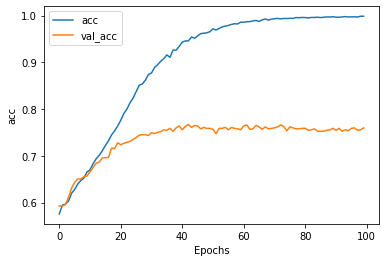

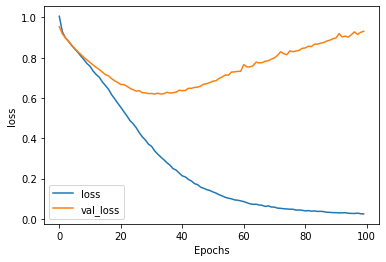

In [47]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")